In [33]:
from sklearn.datasets import fetch_openml
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split


# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
# Access features (pixel values) and labels
X, y = mnist['data'], mnist['target']


/home/adi/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [74]:
# parameters
CATEGORIES = 10
TEST_SIZE = 10000
# hayper parameters
BATCH_SIZE = 1000  





In [67]:
### preprocessing 

# normalize values to be between 0 and 1
X_normalized = X / 255
# insert column of ones as the first column of the data for bias calc down the line 
size = X_normalized.shape[0]
X_tilda = np.insert(X_normalized, 0, np.ones(size), axis=1)

# one hot encode y values 
values = np.arange(CATEGORIES)
one_hot_encoded = np.eye(CATEGORIES,dtype=int)[values]  # TODO what does lines do 
one_hot_encoded
# create a dict to map integers 0-9 to one hot encoded arrays
mapping = {value: one_hot_encoded[index] for index, value in enumerate(values)}
y_one_hot = y.astype(int).map(mapping).values


# split the dataset to a test set and a training set 
X_train, X_test, y_train, y_test = train_test_split(X_tilda, y_one_hot, test_size=TEST_SIZE,
                                                    random_state=42)



In [76]:
# create weight matrix 785 * 10

weights = np.random.rand(X_train.shape[1], CATEGORIES)
weights.shape



(785, 10)

ValueError: cannot reshape array of size 785 into shape (28,28)

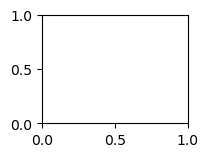

In [71]:
# plot testing 
from matplotlib import pyplot

for i in range(9):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(np.reshape(X_train[i] ,(28,28)), cmap=pyplot.get_cmap('gray'))
pyplot.show()



